### Data Loading and Preparation:
This data set is comprised of the specifications of 205 cars, showing the values of each car for fields like fuel-type, engine-size, horsepower, height, length, and width among others. The problem that I am attempting to solve is to predict the curb weight of a given car in the data set using chosen variables. I also plan to test whether one metric, correlation or covariance, is significantly better than the other if we had to choose just one to base variable selection off of. I plan to examine the distribution of the data to decide if the data should be stratified, examine various EDA metrics to decide which variables to include in my models, and finally compare the scores of both models to be able to choose which is a better fit.

In [1]:
#import all packages needed:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy import stats

In [2]:
#loading data set, showing names of columns for replacement:
url = 'https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Data%20Sets/Module%202/M2_Data.csv'
cars = pd.read_csv(url)
cars.columns

Index(['3', '?', 'alfa-romero', 'gas', 'std', 'two', 'convertible', 'rwd',
       'front', '88.6', '168.8', '64.1', '48.8', '2548', 'dohc', 'four', '130',
       'mpfi', '3.47', '2.68', '9', '111', '5000', '21', '27', '13495'],
      dtype='object')

In [3]:
#assigning column names:
cars = cars.rename(columns = {'3':'symboling','?':'normalized-losses','alfa-romero':'make','gas':'fuel-type','std':'aspiration',
                       'two':'num-of-doors','convertible':'body-style','rwd':'drive-wheels','front':'engine-location',
                      '88.6':'wheel-base','168.8':'length','64.1':'width','48.8':'height','2548':'curb-weight',
                      'dohc':'engine-type','four':'num-of-cylinders','130':'engine-size','mpfi':'fuel-system',
                      '3.47':'bore','2.68':'stroke','9':'compression-ratio','111':'horsepower','5000':'peak-rpm',
                      '21':'city-mpg','27':'highway-mpg','13495':'price'})
cars.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [4]:
#creating subset of only specified variables:
cars = cars[['curb-weight','height', 'width', 'length', 'wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg']]

#showing data types for each field:
types = {}
for i in range(len(cars.columns)):
    types[cars.columns[i]] = type(cars.iloc[0,i])
types

{'curb-weight': numpy.int64,
 'height': numpy.float64,
 'width': numpy.float64,
 'length': numpy.float64,
 'wheel-base': numpy.float64,
 'engine-size': numpy.int64,
 'horsepower': str,
 'peak-rpm': str,
 'city-mpg': numpy.int64}

In [5]:
#transform all values to proper format for EDA:
for i in range(len(cars.horsepower)):
    if cars.iloc[i,5] == '?':
        cars.iloc[i,5] = 0
for i in range(len(cars.horsepower)):
    if cars.iloc[i,6] == '?':
        cars.iloc[i,6] = 0
for i in range(len(cars.horsepower)):
    cars.iloc[i,5] = int(cars.iloc[i,5])
for i in range(len(cars.horsepower)):
    cars.iloc[i,6] = int(cars.iloc[i,6])
for i in range(len(cars.horsepower)):
    if cars.iloc[i,5] == 0:
        cars.iloc[i,5] = np.mean(cars.iloc[:,5])
for i in range(len(cars.horsepower)):
    if cars.iloc[i,6] == 0:
        cars.iloc[i,6] = np.mean(cars.iloc[:,6])
for i in range(len(cars.horsepower)):
    if cars.iloc[i,7] == '?':
        cars.iloc[i,7] = 0
for i in range(len(cars.horsepower)):
    cars.iloc[i,7] = int(cars.iloc[i,7])
for i in range(len(cars.horsepower)):
    if cars.iloc[i,7] == 0:
        cars.iloc[i,7] = np.mean(cars.iloc[:,7])
cars['width'] = cars['width'].astype(int)
cars['length'] = cars['length'].astype(int)
cars['wheel-base'] = cars['wheel-base'].astype(int)
cars['height'] = cars['height'].astype(int)
cars['horsepower'] = cars['horsepower'].astype(int)
cars['peak-rpm'] = cars['peak-rpm'].astype(int)


#showing data types for each field post-transformation:
types = {}
for i in range(len(cars.columns)):
    types[cars.columns[i]] = type(cars.iloc[0,i])
types

{'curb-weight': numpy.int64,
 'height': numpy.int32,
 'width': numpy.int32,
 'length': numpy.int32,
 'wheel-base': numpy.int32,
 'engine-size': numpy.int64,
 'horsepower': numpy.int32,
 'peak-rpm': numpy.int32,
 'city-mpg': numpy.int64}

### Explatory Data Analysis:
The first step in the EDA process is to display the descriptive statistics for all explanatory variables. Here, we can see that the difference between the values in the various quartiles aren't too big across the board and by examining the histograms displayed below of the distributions of all fields, there is none that really seems to jump out as desperately needing to be stratified before splitting into a training and testing set. Examining the correlation and covariance metrics, it is interesting to note that there are only two values out of the eight explanatory variables that have a negative correlation and out of the two of them, only one seems to be statistically significant by the correlation metric alone. Additionally, with the exception of just two variables, all have solid correlation values which would make is difficult to choose which to include in the models unless there is a definite question to be answered which fortunately, we have already defined.

In [6]:
#descriptive statistics of all variables:
cars.describe()

,curb-weight,height,width,length,wheel-base,engine-size,horsepower,peak-rpm,city-mpg
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,2555.602941,53.284314,65.421569,173.583333,98.348039,126.892157,104.210784,5125.612745,25.240196
std,521.960820,2.451007,2.165271,12.280302,6.037767,41.744569,39.613772,478.087829,6.551513
min,1488.000000,47.000000,60.000000,141.000000,86.000000,61.000000,48.000000,4150.000000,13.000000
25%,2145.000000,52.000000,64.000000,166.000000,94.000000,97.000000,70.000000,4800.000000,19.000000
50%,2414.000000,54.000000,65.000000,173.000000,97.000000,119.500000,95.000000,5200.000000,24.000000
75%,2939.250000,55.000000,66.000000,183.000000,102.000000,142.000000,116.000000,5500.000000,30.000000
max,4066.000000,59.000000,72.000000,208.000000,120.000000,326.000000,288.000000,6600.000000,49.000000


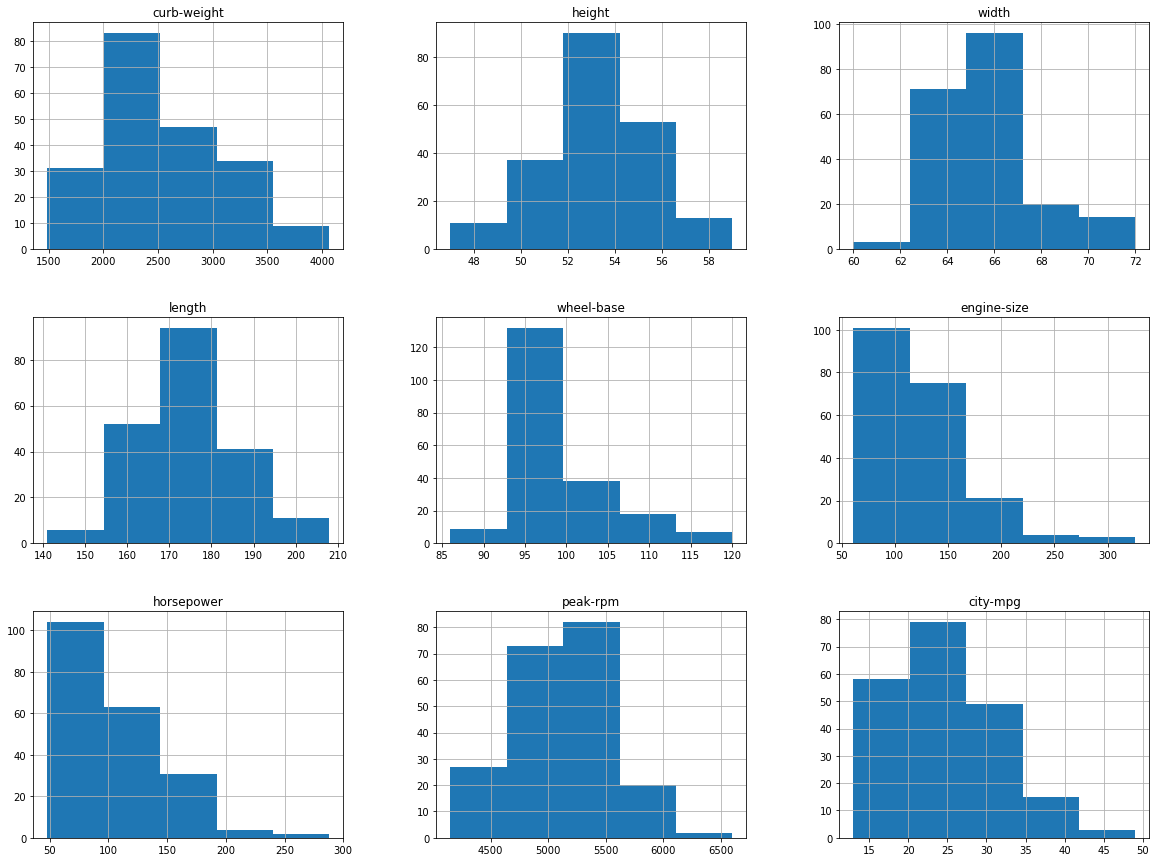

In [7]:
#distribution of values per field for further EDA:
cars.hist(bins=5, figsize=(20, 15))
plt.show()

In [8]:
#correlation matrix as it relates to the curb-weight:
corr_matrix = cars.corr()
corr_matrix['curb-weight'].sort_values(ascending=False)

curb-weight    1.000000
length         0.877800
width          0.862415
engine-size    0.850611
wheel-base     0.783319
horsepower     0.751053
height         0.292849
peak-rpm      -0.266313
city-mpg      -0.758238
Name: curb-weight, dtype: float64

In [9]:
#covariance matrix displayed as table:
car_cov = cars.cov()
car_cov['curb-weight'].sort_values(ascending=False)

curb-weight    272443.097725
engine-size     18533.996378
horsepower      15529.399377
length           5626.552956
wheel-base       2468.611779
width             974.690380
height            374.650391
city-mpg        -2592.894306
peak-rpm       -66456.652057
Name: curb-weight, dtype: float64

### Linear Regression:
For both of these models, I decided to use 10 folds for cross validation and to use the standard *V-fold* method of cross validation. This is because I am trying to define which metric is better, I want to keep the model as simple as possible and try to eliminate any bias that may come up. The descriptions and reasoning for the construction of each model can be found below:

In [10]:
#create training and testing sets:
train_set, test_set = train_test_split(cars, test_size=0.2, random_state=42)
len(train_set) + len(test_set)

204

###### First Linear Regression Model:
The first linear model consists of the variables horsepower, peak-rpm, and engine-size. Most variables show strong correlation values but in this scenario, I wanted to test if covariance can be effective regardless of correlation. To show this, I specifically selected peak-rpm as one of the values since while it has the lowest correlation value, it has the highest covariance value (although both values are listed in the negative). Engine-size and horsepower have the next highest covariance value, but it should be noted that they still have somewhat high correlation values.

In [11]:
#narrowing training set to just selected variables:
cars_vars_a = train_set[['peak-rpm', 'horsepower', 'engine-size']]
cars_pred_a = train_set['curb-weight'].copy()

In [12]:
cars_vars_a.head()

,peak-rpm,horsepower,engine-size
199,5400,114,141
93,5200,69,97
38,5800,86,110
24,5500,68,90
96,5200,69,97


In [13]:
#creating and fitting linear regression model:
lin_reg = LinearRegression()
lin_reg.fit(cars_vars_a, cars_pred_a)

LinearRegression()

In [14]:
#showing predicted values vs actual values:
some_data = cars_vars_a.iloc[:5]
some_labels = cars_pred_a[:5]
print('Predictions: ', lin_reg.predict(some_data))
print('Labels: ', list(some_labels))

Predictions:  [2636.68253442 2168.49161735 2228.45349661 2068.39717041 2168.49161735]
Labels:  [2952, 1951, 2304, 1989, 2037]


In [15]:
#showing RMSE:
cars_preds = lin_reg.predict(cars_vars_a)
lin_mse = mean_squared_error(cars_pred_a, cars_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

256.25611978304437

In [18]:
#showing other metrics:
scores = cross_val_score(lin_reg, cars_vars_a, cars_pred_a, scoring = 'neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ', scores.std())
display_scores(rmse_scores)

Scores:  [240.46462376 187.66382267 320.15286185 221.57718538 390.83507963
 290.64586421 226.71500174 252.95064299 264.97087113 230.12459356]
Mean:  262.6100546920574
Standard Deviation:  55.47299357278407


In [16]:
#narrowing testing set to desired variables for application of model:
cars_vars_test_a = test_set[['peak-rpm', 'horsepower', 'engine-size']]
cars_pred_test_a = test_set['curb-weight'].copy()

In [17]:
#computing R squared value:
a = lin_reg.score(cars_vars_test_a, cars_pred_test_a)
a

0.7412624097164089

###### Second Linear Regression Model:
The second linear model consists of the variables length, width, and engine-size. While all pre-selected explanatory variables have very strong correlation values, I wanted to show how effective the correlation metric is on its own. These variables have the three highest correlation values and while engine-size has the second-highest covariance value, length and width are towards the lower end, nothing noteworthy in that metric. It is worth noting that engine-size is appearing in both models.

In [19]:
#narrowing training set set to just selected variables:
cars_vars_b = train_set[['length', 'width', 'engine-size']]
cars_pred_b = train_set['curb-weight'].copy()

In [20]:
cars_vars_b.head()

,length,width,engine-size
199,188,68,141
93,165,63,97
38,175,65,110
24,157,63,90
96,170,63,97


In [21]:
#creating and fitting linear regression model:
lin_reg = LinearRegression()
lin_reg.fit(cars_vars_b, cars_pred_b)

LinearRegression()

In [22]:
#showing predicted values vs actual values:
some_data = cars_vars_b.iloc[:5]
some_labels = cars_pred_b[:5]
print('Predictions: ', lin_reg.predict(some_data))
print('Labels: ', list(some_labels))

Predictions:  [2996.55448001 2137.23774449 2472.9845457  1942.64643188 2236.20717692]
Labels:  [2952, 1951, 2304, 1989, 2037]


In [23]:
#showing RMSE:
cars_preds = lin_reg.predict(cars_vars_b)
lin_mse = mean_squared_error(cars_pred_b, cars_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

169.8385472742683

In [24]:
#showing other metrics:
scores = cross_val_score(lin_reg, cars_vars_b, cars_pred_b, scoring = 'neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ', scores.std())
display_scores(rmse_scores)

Scores:  [164.10161962 174.45419959 161.16806479 150.61928954 120.7606997
 274.578939   155.97643094 208.03118493 160.56915384 174.57509981]
Mean:  174.4834681765297
Standard Deviation:  39.270087883919864


In [25]:
#narrowing testing set to desired variables for testing model:
cars_test_vars_b = test_set[['length', 'width', 'engine-size']]
cars_test_pred_b = test_set['curb-weight'].copy()

In [26]:
#computing R  squared:
b = lin_reg.score(cars_test_vars_b, cars_test_pred_b)
b

0.9180623274776668

In [27]:
#showing difference between R squared of first model and second model:
b - a

0.17679991776125792

### Evaluation:
Looking at the scoring metrics of both models, the results are *drastically* different with the second model scoring better than the first. Using just the correlation metric as a decider, the RMSE is approximately 170, while focusing on the covariance metric the RMSE is a whopping 256. While this is by no means a definite statement that covariance should be ignored and the focus should be solely on correlation (especially on only 205 rows and three variables per model), it does produce some startling results. Computing the R-Squared as well, the first model only comes out to around 74% while the second model comes out to 91%, a difference of close to 18%.